## Load Modules

In [103]:
import seaborn as sns
from typing import Union
from sklearn.decomposition import non_negative_factorization
import numpy as np
import scanpy as sc
from pathlib import Path
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm

## Helper Functions

In [221]:
def non_negative_factorization_reimplementation(
        X: np.array, 
        W: Union[None, np.array]=None, 
        H: Union[None, np.array]=None, 
        n_components: Union[None, int]=None, 
        update_H: bool=True,
        max_iter: int=200
):
    if n_components == None:
        n_components = min(X.shape)
    if W == None:
        W = np.ones((X.shape[0], n_components))
    if H == None:
        H = np.ones((n_components, X.shape[1]))
    
    for i in tqdm(range(max_iter)):
        W = (W.T * (H @ X.T) / (H @ H.T @ W.T)).T
        if update_H:
            H = (H * (W.T @ X) / (W.T @ W @ H))
    return W, H, max_iter

def cosine_similarity_rows(A, B):
    norms_A = np.linalg.norm(A, axis=1)
    norms_B = np.linalg.norm(B, axis=1)
    dot_products = np.einsum('ij,ij->i', A, B)
    return dot_products / (norms_A * norms_B)

def create_folders(base_path: str, structure: dict, current_path: Union[str, Path] = None) -> None:
    if current_path is None:
        current_path = Path(base_path)
    Path(current_path).mkdir(exist_ok=True)
    for key, value in structure.items():
        new_path = current_path / str(key)
        if isinstance(value, dict):
            Path(new_path).mkdir(exist_ok=True)
            create_folders(base_path, value, new_path)

def nmf_transfer_sklearn(adata_query, adata_reference, n_components):
    shared_genes_mask_reference = np.isin(adata_reference.var_names, adata_query.var_names)
    shared_genes = adata_reference[:, shared_genes_mask_reference].var_names
    shared_genes_mask_query = np.isin(adata_query.var_names, adata_reference.var_names)
    adata_query_array = adata_query.X.toarray().copy()
    # NMF run 1
    W_init, H_init, _ = non_negative_factorization(adata_reference.X.toarray(), n_components=n_components)
    # NMF run 2
    W, H, _ = non_negative_factorization(adata_query[:, shared_genes].X.toarray(), H=H_init[:, shared_genes_mask_reference], update_H=False)
    return {
        "adata_query_array": adata_query[:, shared_genes].X.toarray().copy(),
        "adata_reference_array": adata_reference.X.toarray().copy(),
        "shared_genes_mask_query": shared_genes_mask_query,
        "shared_genes_mask_reference": shared_genes_mask_reference,
        "W_init": W_init,
        "H_init": H_init,
        "W": W,
        "H": H,
    }

def benchmark_reconstruction(count_matrix, count_matrix_reconstructed):
    log_original = np.log1p(count_matrix)
    log_reconstructed = np.log1p(count_matrix_reconstructed)

    row_means_original = count_matrix.mean(axis=1)
    row_means_reconstructed = count_matrix_reconstructed.mean(axis=1)
    col_means_original = count_matrix.mean(axis=0)
    col_means_reconstructed = count_matrix_reconstructed.mean(axis=0)

    fig, axes = plt.subplots(3, 2, figsize=(6, 8))

    sns.heatmap(log_original, ax=axes[0, 0], cmap="magma", cbar=True)
    axes[0, 0].set_title("Log Transformed \n Original Count Matrix")

    sns.heatmap(log_reconstructed, ax=axes[0, 1], cmap="magma", cbar=True)
    axes[0, 1].set_title("Log Transformed \n Reconstructed Count Matrix")

    pearson_row, _ = pearsonr(row_means_original, row_means_reconstructed)
    axes[1, 0].scatter(row_means_original, row_means_reconstructed, alpha=0.5, color="black")
    axes[1, 0].plot([row_means_original.min(), row_means_original.max()], 
                    [row_means_original.min(), row_means_original.max()], 
                    linestyle="dashed", color="red")
    axes[1, 0].set_xlabel("Cell Mean (Original)")
    axes[1, 0].set_ylabel("Cell Mean (Reconstructed)")
    axes[1, 0].set_title("Cell-wise Mean Comparison")
    axes[1, 0].text(0.05, 0.9, f"Pearson r = {pearson_row:.2f}", 
                    transform=axes[1, 0].transAxes, fontsize=10, color="blue")
    
    pearson_col, _ = pearsonr(col_means_original, col_means_reconstructed)
    axes[1, 1].scatter(col_means_original, col_means_reconstructed, alpha=0.5, color="black")
    axes[1, 1].plot([col_means_original.min(), col_means_original.max()], 
                    [col_means_original.min(), col_means_original.max()], 
                    linestyle="dashed", color="red")
    axes[1, 1].set_xlabel("Gene Mean (Original)")
    axes[1, 1].set_ylabel("Gene Mean (Reconstructed)")
    axes[1, 1].set_title("Gene-wise Mean Comparison")
    axes[1, 1].text(0.05, 0.9, f"Pearson r = {pearson_col:.2f}", 
                    transform=axes[1, 1].transAxes, fontsize=10, color="blue")

    sns.violinplot(cosine_similarity_rows(count_matrix, count_matrix_reconstructed), ax=axes[2, 0])
    axes[2, 0].set_title("Cosine Similarity Cells")
    sns.violinplot(cosine_similarity_rows(count_matrix.T, count_matrix_reconstructed.T), ax=axes[2, 1])
    axes[2, 1].set_title("Cosine Similarity Genes")

    sns.despine()
    plt.tight_layout()
    plt.show()

In [3]:
create_folders(
    str(Path.cwd()),
    {
        "data": {
            "inputQuery": {},
            "inputRef": {},
            "nico_out": {},
        }
    }
)

In [90]:
celltype = "Stem/TA"
adata_sp = (lambda x: x[x.obs["nico_ct"] == celltype])(sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad"))
#adata_sp = sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad")
adata_sc = (lambda x: x[x.obs["cluster"] == celltype])(sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad"))
#adata_sc = sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad")
sc.pp.filter_genes(adata_sp, min_counts=50)
sc.pp.filter_genes(adata_sc, min_counts=50)
shared_genes_mask_sc = np.isin(adata_sc.var_names, adata_sp.var_names)
shared_genes_mask_sp = np.isin(adata_sp.var_names, adata_sc.var_names)
shared_genes = adata_sc[:, shared_genes_mask_sc].var_names

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_counts"] = number
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_counts"] = number


In [225]:
n_components = 3
res_1 = nmf_transfer_sklearn(
    adata_query=adata_sp,
    adata_reference=adata_sc,
    n_components=n_components
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


### Baseline Reconstruction Quality of Spatial Data

n_components=3


/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


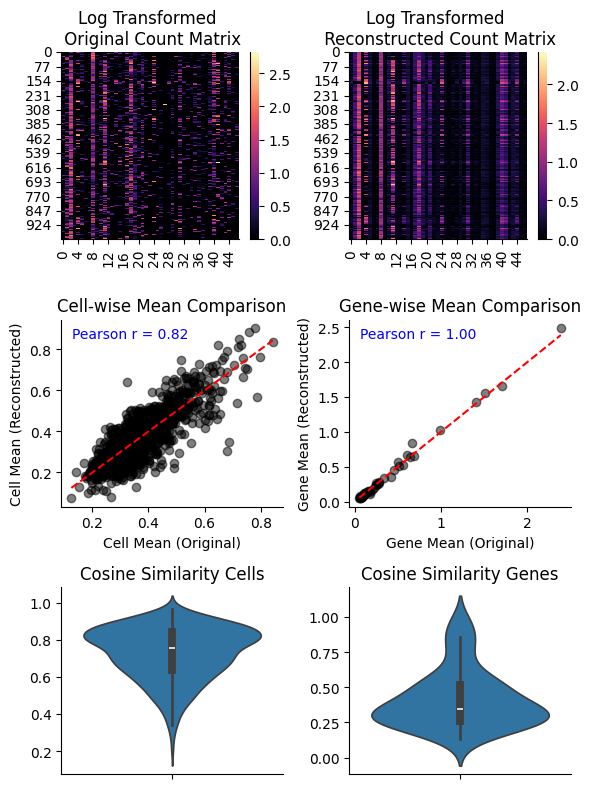

In [235]:
# Baseline reconstruction using sklearns NMF implementation
print(f"{n_components=}")
(lambda X, nmf_func: benchmark_reconstruction(
    X, 
    (lambda W, H, n_iter: W @ H)(
        *nmf_func(X, n_components=n_components)
    )
))(
    adata_sp[:, shared_genes].X.toarray(),
    non_negative_factorization
)

100%|██████████| 200/200 [00:00<00:00, 14251.07it/s]


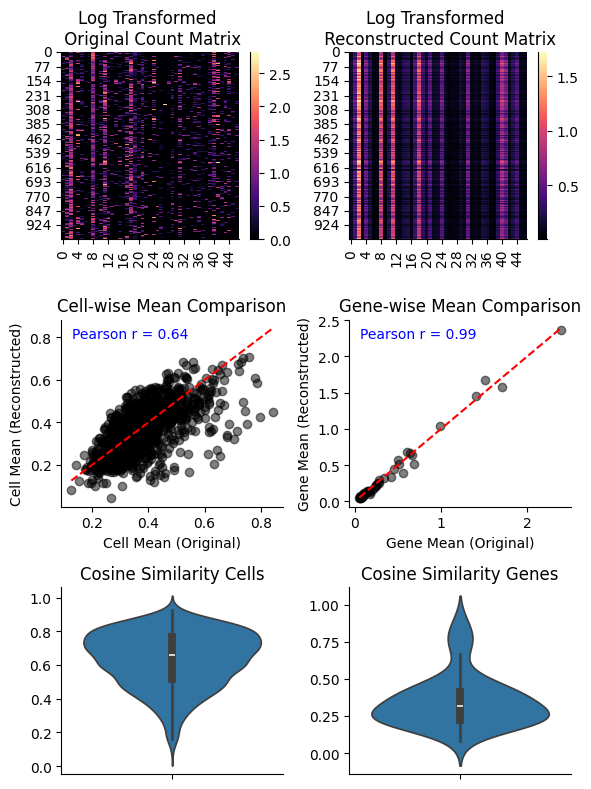

In [233]:
# Baseline Reconstruction using manual implementation of NMF
print(f"{n_components=}")
(lambda X, nmf_func: benchmark_reconstruction(
    X, 
    (lambda W, H, n_iter: W @ H)(
        *nmf_func(X, n_components=2)
    )
))(
    adata_sp[:, shared_genes].X.toarray(),
    non_negative_factorization_reimplementation
)

### Reconstruction Quality of single cell reference data

n_components=3


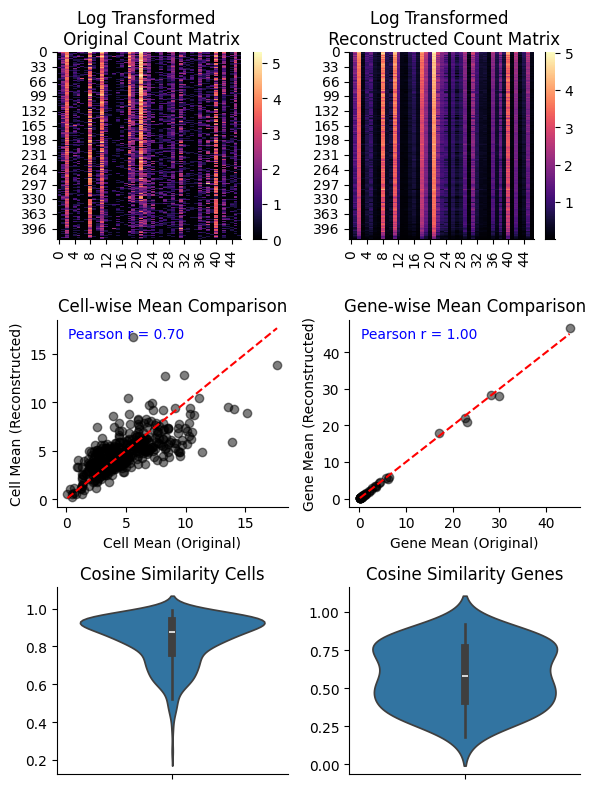

In [229]:
print(f"{n_components=}")
benchmark_reconstruction(
    res_1["adata_reference_array"][:, res_1["shared_genes_mask_reference"]], 
    res_1["W_init"] @ res_1["H_init"][:, res_1["shared_genes_mask_reference"]]
)

### Reconstruction Quality of spatial data with H-Matrix (gene by factor matrix) initialized and fixed from previous single cell NMF

n_components=3


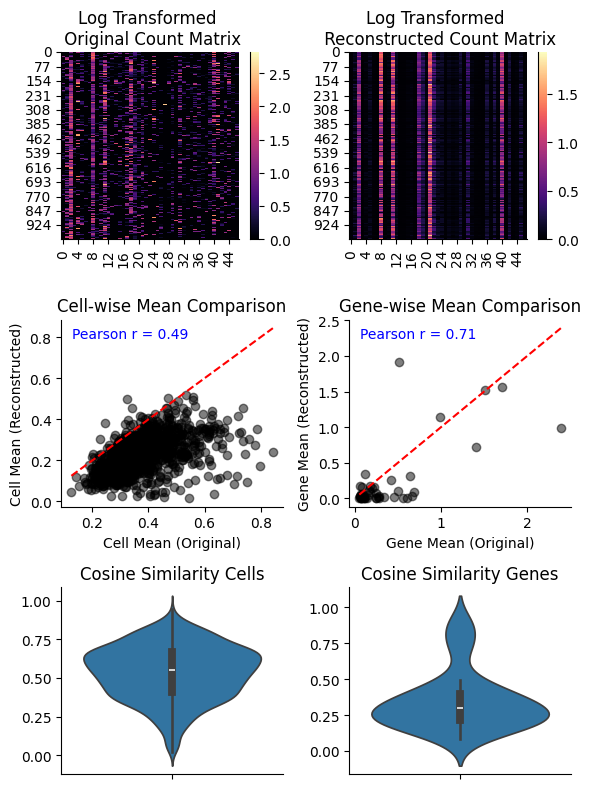

In [230]:
print(f"{n_components=}")
benchmark_reconstruction(
    res_1["adata_query_array"], 
    res_1["W"] @ res_1["H"]
)

### Randomly Reconstructed Matrix by sampling featurewise

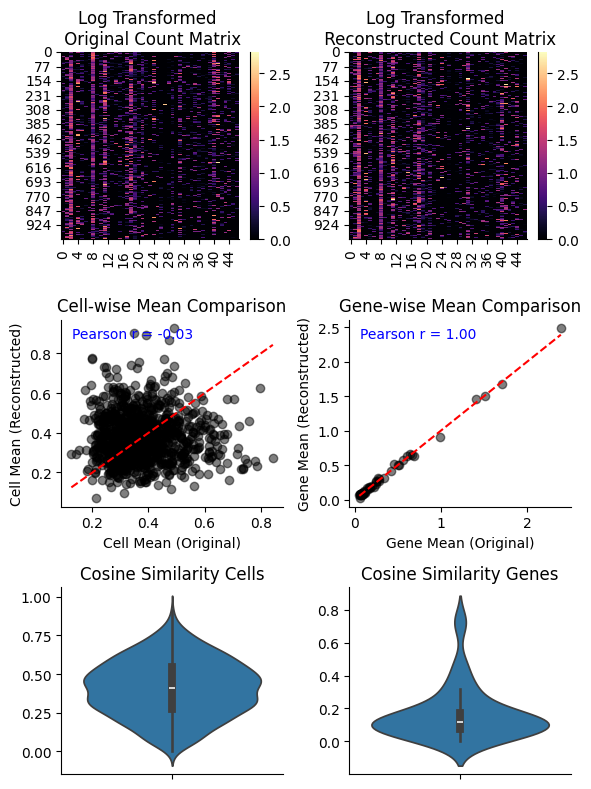

In [231]:
benchmark_reconstruction(
    adata_sp[:, shared_genes].X.toarray(), 
    np.apply_along_axis(lambda col: np.random.choice(col, size=len(col), replace=True), axis=0, arr=adata_sp[:, shared_genes].X.toarray())
)